In [1]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, lowPassFIR, pnorm, sincInterp
from optic.metrics import signal_power
from optic.plot import eyediagram

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
figsize(8, 3)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Canais-limitados-em-banda" data-toc-modified-id="Canais-limitados-em-banda-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Canais limitados em banda</a></span></li><li><span><a href="#Referências" data-toc-modified-id="Referências-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Receptores ótimos para canais AWGN

<img src="./figuras/Fig1.png" width="900">
 <center>Fig.1: Diagrama de blocos de um sistema de transmissão digital genérico.</center>

##  Canais limitados em banda

Na maioria das situações práticas, a transmissão digital deve ser estabelecida por meio de um canal cuja banda de frequências disponível para comunicação é limitada. Desse modo, existirão restrições sobre o conteúdo de frequências que os sinais transmitidos e recebidos poderão conter. 

Na análise que segue, considere que o canal de comunicações pode ser modelado como um sistema linear com uma resposta ao impulso $h(t)$ e resposta em frequência $H(f)$ limitada a uma banda de $B$ Hz, de modo que 

$$
\begin{equation}
H(f) = \begin{cases}|H(f)|e^{\theta(f)}, & |f|<B \\ 0, & \text { caso contrário.}\end{cases}
\end{equation}
$$

e $H(f) = \int_{-\infty}^{\infty}h(t)e^{-2\pi f t} dt$, $|H(f)|$ é a resposta de amplitude e $\theta(f)$ a resposta de fase do canal. A partir da resposta de fase podemos definir o *atraso de grupo* como 

$$
\begin{equation}
\tau(f)=-\frac{1}{2 \pi} \frac{d \theta(f)}{d f}.
\end{equation}
$$

O atraso de grupo corresponde ao intervalo de tempo com que cada componente de frequência do sinal transmitido atravessa o canal linear. Um canal linear não causará distorção nos sinais por ele transmitidos se, por todo o espectro do sinal transmitido, $|H(f)|$ for constante e $\theta(f)$ for uma função linear de $f$, ou seja, se o atraso de grupo for constante.

Considere o modelo de canal em que os sinais transmitidos são afetados apenas por ruído branco gaussiano aditivo (*additive white Gaussian noise* - AWGN). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média $\mu$ igual a zero e com uma certa variância $\sigma^2$. Desse modo, seja $s(t)$ o sinal enviado pelo transmissor ao canal, o modelo de canal AWGN assume que um ruído $n(t)$ será adicionado ao sinal de informação durante o processo de comunicação, como indicado na figura a seguir

<img src="./figuras/Fig12.png" width="700">
<center>Fig.2: Esquemático de um sistema de transmissão digital via canal linear e AWGN.</center>

em que $r(t)$ representa o sinal ruidoso na entrada do receptor.

Assuma que em cada intervalo de sinalização $T_s$, o transmissor envia um sinal $s_m(t)$ dentre os $M$ possíveis do esquema de modulação utilizado, i.e. $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$. Considere que no intervalo de $0\leq t \leq T_s$ o transmissor enviou a sinal $s_m(t)$. Uma vez que o canal adiciona ruído ao sinal transmitido, o sinal recebido $r(t)$ no intervalo $0\leq t \leq T_s$ pode ser expresso como

$$\begin{equation}\label{awgnch_eq1} r(t) = s_m(t) + n(t)\end{equation}$$

em que $n(t)$ é uma função amostra de um processo estocástico gaussiano com densidade espectral de potência $S_n(f)=\frac{N_0}{2}$.

c:\users\edson\onedrive\documentos\github\opticommpy-private\optic\dsp.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  y[:, n] = np.convolve(x[:, n], h, mode="same")


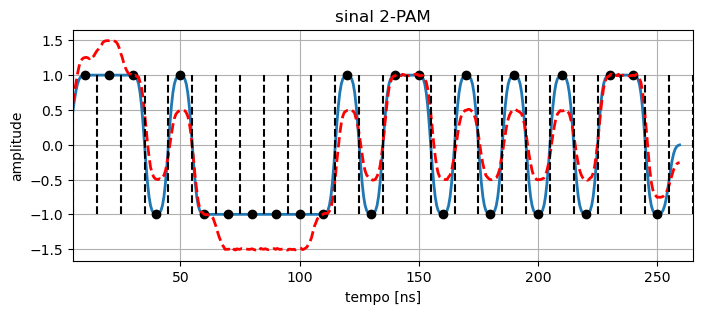

In [6]:
M = 2

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# gera sequência pseudo-aleatória de bits
bitsTx = np.random.randint(2, size = int(25*np.log2(M)))

# gera sequência de símbolos modulados
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = np.insert(symbTx,0, 0)

# resposta do canal linear
h_ch = np.array([0, 0.25, 1, 0.25])

# upsampling
symbolsUp = upsample(symbTx, SpS)
h_ch_Up = upsample(h_ch, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(1/Fa)/1e-9

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(symbTx, SpS)
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=2)
plt.plot(t, symbolsUp.real,'ko')
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude')
plt.title('sinal '+str(M)+'-PAM')
plt.grid()

# canal linear
sigRx = firFilter(h_ch_Up, sigTx)
sigRx = sigRx.real

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.000050  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

plt.figure(2)
plt.plot(t, sigRx + ruido,'r--',alpha=1, linewidth=2)

t = (0.5*Ts + np.arange(0, symbTx.size+1)*Ts)/1e-9
plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
plt.xlim(min(t), max(t));

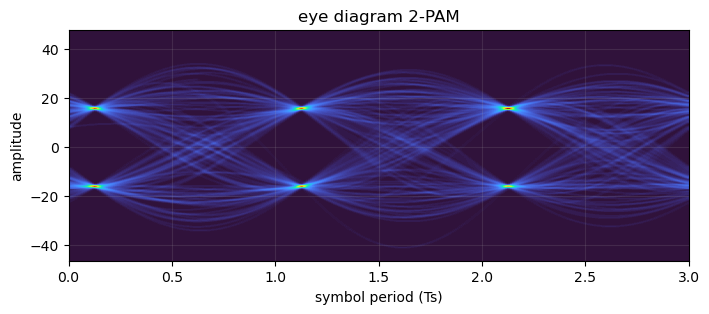

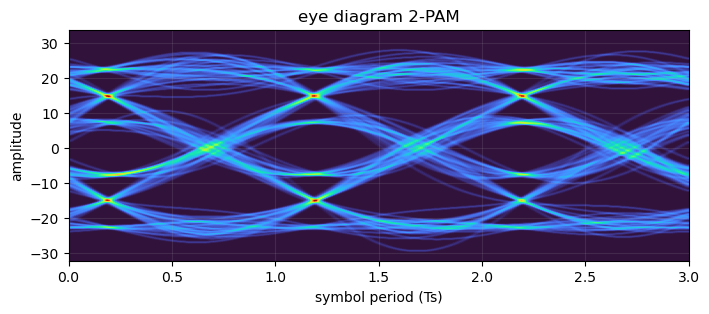

In [12]:
# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(250000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# resposta do canal linear
h_ch = np.array([0, 0.25, 1, 0.25])

# upsampling
symbolsUp = upsample(symbTx, SpS)
h_ch_Up = upsample(h_ch, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx.real)

# canal linear
sigRx = firFilter(h_ch_Up, sigTx)
sigRx = pnorm(sigRx.real)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.00050 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# diagrama de olho
Nsamples = sigTx.size
eyediagram(firFilter(pulse, sigTx), Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
eyediagram(firFilter(pulse, sigRx+ruido), Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')

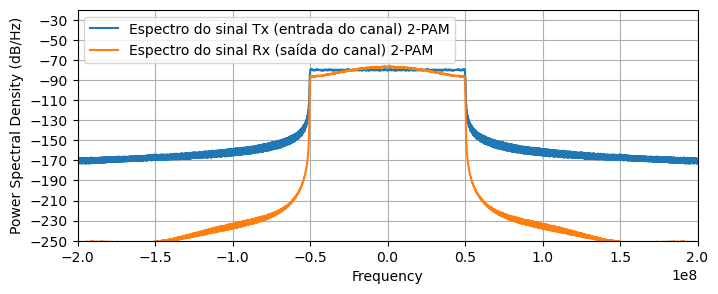

In [13]:
# plot PSD
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-250,-20);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx (entrada do canal) '+ str(M) +'-PAM')
plt.psd(pnorm(firFilter(pulse, sigRx)),Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do canal) '+ str(M) +'-PAM')
plt.legend(loc='upper left');

## Referências

[1] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.